<img src="images/dask_horizontal.svg" align="right" width="30%">

# Lazy execution

Here we discuss some of the concepts behind dask, and lazy execution of code. You do not need to go through this material if you are eager to get on with the tutorial, but it may help understand the concepts underlying dask, how these things fit in with techniques you might already be using, and how to understand things that can go wrong.

## Prelude

As Python programmers, you probably already perform certain *tricks* to enable computation of larger-than-memory datasets, parallel execution or delayed/background execution. Perhaps with this phrasing, it is not clear what we mean, but a few examples should make things clearer. The point of Dask is to make simple things easy and complex things possible!

Aside from the [detailed introduction](http://dask.pydata.org/en/latest/), we can summarize the basics of Dask as follows:
|
- process data that doesn't fit into memory by breaking it into blocks and specifying task chains
- parallelize execution of tasks across cores and even nodes of a cluster
- move computation to the data rather than the other way around, to minimize communication overhead

All of this allows you to get the most out of your computation resources, but program in a way that is very familiar: for-loops to build basic tasks, Python iterators, and the NumPy (array) and Pandas (dataframe) functions for multi-dimensional or tabular data, respectively.

The remainder of this notebook will take you through the first of these programming paradigms. This is more detail than some users will want, who can skip ahead to the iterator, array and dataframe sections; but there will be some data processing tasks that don't easily fit into those abstractions and need to fall back to the methods here.

We include a few examples at the end of the notebooks showing that the ideas behind how Dask is built are not actually that novel, and experienced programmers will have met parts of the design in other situations before. Those examples are left for the interested.

## Dask is a graph execution engine

Dask allows you to construct a prescription for the calculation you want to carry out. That may sound strange, but a simple example will demonstrate that you can achieve this while programming with perfectly ordinary Python functions and for-loops. We saw this in the previous notebook.

In [8]:
from dask import delayed

@delayed
def inc(x):
    return x + 1

@delayed
def add(x, y):
    return x + y

Here we have used the delayed annotation to show that we want these functions to operate lazily — to save the set of inputs and execute only on demand. `dask.delayed` is also a function which can do this, without the annotation, leaving the original function unchanged, e.g.,
```python
    delayed_inc = delayed(inc)
```

In [36]:
# this looks like ordinary code
x = inc(15)
y = inc(30)
total = add(x, y)
# x, y and total are all delayed objects. 
# They contain a prescription of how to carry out the computation

Calling a delayed function created a delayed object (`x, y, total`) which can be examined interactively. Making these objects is somewhat equivalent to constructs like the `lambda` or function wrappers (see below). Each holds a simple dictionary describing the task graph, a full specification of how to carry out the computation.

We can visualize the chain of calculations that the object `total` corresponds to as follows; the circles are functions, rectangles are data/results.

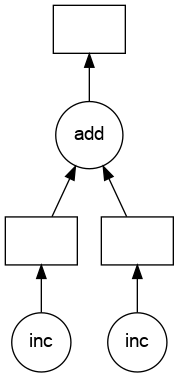

In [3]:
total.visualize()

But so far, no functions have actually been executed. This demonstrated the division between the graph-creation part of Dask (`delayed()`, in this example) and the graph execution part of Dask.

To run the "graph" in the visualization, and actually get a result, do:

In [4]:
# execute all tasks
total.compute()

47

**Why should you care about this?**

By building a specification of the calculation we want to carry out before executing anything, we can pass the specification to an *execution engine* for evaluation. In the case of Dask, this execution engine could be running on many nodes of a cluster, so you have access to the full number of CPU cores and memory across all the machines. Dask will intelligently execute your calculation with care for minimizing the amount of data held in memory, while parallelizing over the tasks that make up a graph. Notice that in the animated diagram below, where four workers are processing the (simple) graph, execution progresses vertically up the branches first, so that intermediate results can be expunged before moving onto a new branch.

With `delayed` and normal pythonic looped code, very complex graphs can be built up and passed on to Dask for execution. See a nice example of [simulated complex ETL](https://blog.dask.org/2017/01/24/dask-custom) work flow.

![this](images/grid_search_schedule.gif)

### Exercise

We will apply `delayed` to a real data processing task, albeit a simple one.

Consider reading three CSV files with `pd.read_csv` and then measuring their total length. We will consider how you would do this with ordinary Python code, then build a graph for this process using delayed, and finally execute this graph using Dask, for a handy speed-up factor of more than two (there are only three inputs to parallelize over).

In [5]:
%run prep.py -d accounts

Created CSV accounts in 3.99s
Created JSON accounts in 22.36s


In [6]:
import pandas as pd
import os
filenames = [os.path.join('data', 'accounts.%d.csv' % i) for i in [0, 1, 2]]
filenames

['data/accounts.0.csv', 'data/accounts.1.csv', 'data/accounts.2.csv']

In [7]:
%%time

# normal, sequential code
a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])
c = pd.read_csv(filenames[2])

na = len(a)
nb = len(b)
nc = len(c)

total = sum([na, nb, nc])
print(total)

3000000
CPU times: user 372 ms, sys: 7.91 ms, total: 380 ms
Wall time: 379 ms


Your task is to recreate this graph again using the delayed function on the original Python code. The three functions you want to delay are `pd.read_csv`, `len` and `sum`. 

```python
delayed_read_csv = delayed(pd.read_csv)
a = delayed_read_csv(filenames[0])
...

total = ...

# execute
%time total.compute()   
```

CPU times: user 1.98 ms, sys: 8.18 ms, total: 10.2 ms
Wall time: 49.5 ms


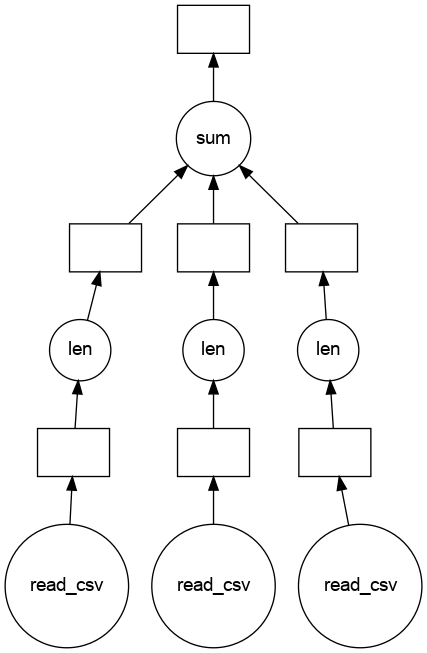

In [9]:
%%time

# normal, sequential code
a = delayed(pd.read_csv)(filenames[0])
b = delayed(pd.read_csv)(filenames[1])
c = delayed(pd.read_csv)(filenames[2])

na = delayed(len)(a)
nb = delayed(len)(b)
nc = delayed(len)(c)

total = delayed(sum)([na, nb, nc])
total.visualize()

Next, repeat this using loops, rather than writing out all the variables.

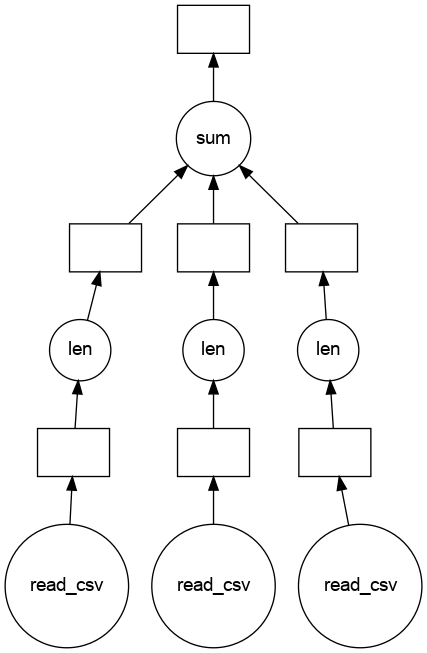

In [17]:
## concise version
csvs = [delayed(pd.read_csv)(fn) for fn in filenames]
lens = [delayed(len)(csv) for csv in csvs]
total = delayed(sum)(lens)

total.visualize() 

In [13]:
## verbose version
delayed_read_csv = delayed(pd.read_csv)
a = delayed_read_csv(filenames[0])
b = delayed_read_csv(filenames[1])
c = delayed_read_csv(filenames[2])

delayed_len = delayed(len)
na = delayed_len(a)
nb = delayed_len(b)
nc = delayed_len(c)

delayed_sum = delayed(sum)

total = delayed_sum([na, nb, nc])
%time print(total.compute())


## concise version
csvs = [delayed(pd.read_csv)(fn) for fn in filenames]
lens = [delayed(len)(csv) for csv in csvs]
total = delayed(sum)(lens)
%time print(total.compute())


3000000
CPU times: user 426 ms, sys: 60.1 ms, total: 486 ms
Wall time: 215 ms
3000000
CPU times: user 437 ms, sys: 16.4 ms, total: 454 ms
Wall time: 211 ms


**Notes**

Delayed objects support various operations:
```python
    x2 = x + 1
```

if `x` was a delayed result (like `total`, above), then so is `x2`. Supported operations include arithmetic operators, item or slice selection, attribute access and method calls - essentially anything that could be phrased as a `lambda` expression.

Operations which are *not* supported include mutation, setter methods, iteration (for) and bool (predicate).

## Appendix: Further detail and examples

The following examples show that the kinds of things Dask does are not so far removed from normal Python programming when dealing with big data. These examples are **only meant for experts**, typical users can continue with the next notebook in the tutorial.

### Example 1: simple word count

This directory contains a file called `README.md`. How would you count the number of words in that file?

The simplest approach would be to load all the data into memory, split on whitespace and count the number of results. Here we use a regular expression to split words.

In [1]:
import re
splitter = re.compile('\w+')
with open('README.md', 'r') as f:
    data = f.read()
result = len(splitter.findall(data))
result

753

The trouble with this approach is that it does not scale - if the file is very large, it, and the generated list of words, might fill up memory. We can easily avoid that, because we only need a simple sum, and each line is totally independent of the others. Now we evaluate each piece of data and immediately free up the space again, so we could perform this on arbitrarily-large files. Note that there is often a trade-off between time-efficiency and memory footprint: the following uses very little memory, but may be slower for files that do not fill a large faction of memory. In general, one would like chunks small enough not to stress memory, but big enough for efficient use of the CPU.

In [12]:
result = 0
with open('README.md', 'r') as f:
    for line in f:                               # Read file f by lines.
        result += len(splitter.findall(line))
result

753

Again think through graph. If you tried something like `len(delayed(splitter.findall(line)))`, then you'll get error _"delayed object has no len() method."_

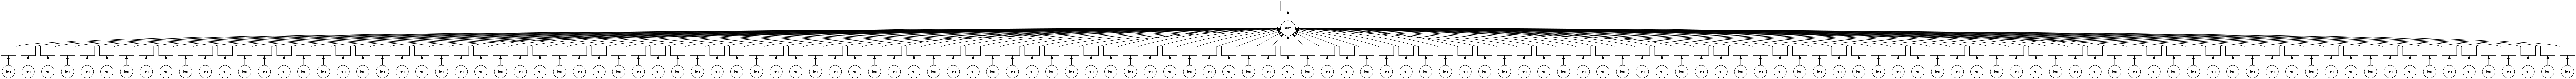

In [20]:
result = 0
counts = []
with open('README.md', 'r') as f:
    for line in f:
        words = delayed(len)(splitter.findall(line))
        counts.append(words)
result = delayed(sum)(counts)
result.visualize()

In [19]:
result.compute()

753

### Example 2: background execution

There are many tasks that take a while to complete, but don't actually require much of the CPU, for example anything that requires communication over a network, or input from a user. In typical sequential programming, execution would need to halt while the process completes, and then continue execution. That would be dreadful for user experience (imagine the slow progress bar that locks up the application and cannot be canceled), and wasteful of time (the CPU could have been doing useful work in the meantime).

For example, we can launch processes and get their output as follows:
```python
    import subprocess
    p = subprocess.Popen(command, stdout=subprocess.PIPE)
    p.returncode
```

The task is run in a separate process, and the return-code will remain `None` until it completes, when it will change to `0`. To get the result back, we need `out = p.communicate()[0]` (which would block if the process was not complete).

Similarly, we can launch Python processes and threads in the background. Some methods allow mapping over multiple inputs and gathering the results, more on that later.  The thread starts and the cell completes immediately, but the data associated with the download only appears in the queue object some time later.

In [21]:
# Edit sources.py to configure source locations
import sources
sources.lazy_url

'http://www.google.com'

In [28]:
import threading
import queue
import urllib

def get_webdata(url, q):
    u = urllib.request.urlopen(url)
    # raise ValueError
    q.put(u.read())

q = queue.Queue()
t = threading.Thread(target=get_webdata, args=(sources.lazy_url, q))
t.start()

In [29]:
# fetch result back into this thread. If the worker thread is not done, this would wait.
q.get()

b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="zh-TW"><head><meta content="text/html; charset=UTF-8" http-equiv="Content-Type"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>Google</title><script nonce="7uMglZ1-oT7MZQzffzzCrw">(function(){window.google={kEI:\'UcKIYvewEJCLmAWEjKaYDQ\',kEXPI:\'0,1302536,56873,6059,206,2415,2389,2316,383,246,5,1354,4013,1123753,1197718,683,380090,16114,28684,17572,4858,1362,9291,3023,4751,12834,4998,13228,3847,10622,7432,15309,5081,1593,1279,2742,149,1103,840,1983,213,4101,108,3406,606,2023,1777,520,14670,3227,2845,7,5599,11851,11625,4695,1851,2614,13142,3,576,6460,148,13975,4,1528,2304,6462,25650,2658,7356,13659,4437,13627,3159,5830,2527,4094,4052,3,3541,1,42160,2,14016,1931,12185,11623,5679,1021,2380,2718,11306,6991,2,6,7718,4568,6256,23421,830,422,4570,2,6,1257,14967,1555,2778,20,2063,2934,1072,1395,445,2,2,1,24626,152,1417,1,436,8155,6582,799,2448,595,858,7872,2907,7

Consider: what would you see if there had been an exception within the `get_webdata` function? You could uncomment the `raise` line, above, and re-execute the two cells. What happens? Is there any way to debug the execution to find the root cause of the error?

### Example 3: delayed execution

There are many ways in Python to specify the computation you want to execute, but only run it *later*.

In [30]:
def add(x, y):
    return x + y

# Sometimes we defer computations with strings
x = 15
y = 30
z = "add(x, y)"
eval(z)

45

In [31]:
# we can use lambda or other "closure"
x = 15
y = 30
z = lambda: add(x, y)
z()

45

In [32]:
# A very similar thing happens in functools.partial

import functools
z = functools.partial(add, x, y)
z()

45

In [33]:
# Python generators are delayed execution by default
# Many Python functions expect such iterable objects

def gen():
    res = x
    yield res
    res += y
    yield res

g = gen()

In [34]:
# run once: we get one value and execution halts within the generator
# run again and the execution completes
next(g)

15

### Dask graphs

Any Dask object, such as `total`, above, has an attribute which describes the calculations necessary to produce that result. Indeed, this is exactly the graph that we have been talking about, which can be visualized. We see that it is a simple dictionary, in which the keys are unique task identifiers, and the values are the functions and inputs for calculation.

`delayed` is a handy mechanism for creating the Dask graph, but the adventurous may wish to play with the full flexibility afforded by building the graph dictionaries directly. Detailed information can be found [here](http://dask.pydata.org/en/latest/graphs.html).

In [37]:
total.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7f65581369a0>
 0. inc-929a6635-79b9-4029-9a3d-95bd089f1aec
 1. inc-91c816df-11f8-4eaf-a247-e678736cf90f
 2. add-d3bd6c4175e000eca9452dadb575a1e8

In [38]:
dict(total.dask)

{'add-d3bd6c4175e000eca9452dadb575a1e8': (<function _operator.add(a, b, /)>,
  'inc-91c816df-11f8-4eaf-a247-e678736cf90f',
  'inc-929a6635-79b9-4029-9a3d-95bd089f1aec'),
 'inc-91c816df-11f8-4eaf-a247-e678736cf90f': (<function __main__.inc(x)>, 15),
 'inc-929a6635-79b9-4029-9a3d-95bd089f1aec': (<function __main__.inc(x)>, 30)}